In [1]:
import os
import sys
from pathlib import Path

from df_collector import df_collector
from model_settings import ms
ms.find_root(Path())
parameter_dir = os.path.join(ms.root,ms.tuned_parameters)
sys.path.append(parameter_dir)
os.listdir(parameter_dir)

['asian_parameters.py', 'barrier_parameters.py', '__pycache__']

In [2]:
df_collector.root = os.path.join(ms.root)

In [3]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]

In [4]:
data

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,risk_free_rate,theta,kappa,rho,eta,v0,calculation_date,date,barrier_price
0,1274.0,1146.6,637.0,60,Down,Out,call,DownOut,0.0,0.020858,0.001578,2.008515e-01,3.183380,-1.000000,0.601996,0.012430,2012-01-03 13:00:22.494,2012-01-03,135.143405
1,1274.0,1146.6,637.0,60,Down,Out,put,DownOut,0.0,0.020858,0.001578,2.008515e-01,3.183380,-1.000000,0.601996,0.012430,2012-01-03 13:00:22.494,2012-01-03,11.783221
2,1274.0,1146.6,637.0,60,Down,In,call,DownIn,0.0,0.020858,0.001578,2.008515e-01,3.183380,-1.000000,0.601996,0.012430,2012-01-03 13:00:22.494,2012-01-03,0.066615
3,1274.0,1146.6,637.0,60,Down,In,put,DownIn,0.0,0.020858,0.001578,2.008515e-01,3.183380,-1.000000,0.601996,0.012430,2012-01-03 13:00:22.494,2012-01-03,0.012142
4,1274.0,1146.6,637.0,90,Down,Out,call,DownOut,0.0,0.020858,0.001578,2.008515e-01,3.183380,-1.000000,0.601996,0.012430,2012-01-03 13:00:22.494,2012-01-03,145.869765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067275,5857.0,6442.7,8785.5,540,Up,In,put,UpIn,0.0,0.012687,0.041813,2.286232e-09,4.067045,-0.717809,1.487001,0.121595,2024-10-14 15:26:27.717,2024-10-14,20.718472
4067276,5857.0,6442.7,8785.5,720,Up,Out,call,UpOut,0.0,0.012687,0.041813,2.286232e-09,4.067045,-0.717809,1.487001,0.121595,2024-10-14 15:26:27.717,2024-10-14,107.869068
4067277,5857.0,6442.7,8785.5,720,Up,Out,put,UpOut,0.0,0.012687,0.041813,2.286232e-09,4.067045,-0.717809,1.487001,0.121595,2024-10-14 15:26:27.717,2024-10-14,293.413202
4067278,5857.0,6442.7,8785.5,720,Up,In,call,UpIn,0.0,0.012687,0.041813,2.286232e-09,4.067045,-0.717809,1.487001,0.121595,2024-10-14 15:26:27.717,2024-10-14,0.000000


In [5]:
from convsklearn import relativize
data = relativize(data)

In [6]:
import numpy as np
def noisify(x):
    return x + np.random.normal(scale=x*0.01)

relative_pricename = [n for n in data.columns if n.find('relative_')!=-1 and n.find('_price')!=-1][0]
relative_observed = data[relative_pricename].values
relative_observed[relative_observed>0] = noisify(relative_observed[relative_observed>0])
targetname = 'relative_observed'
data[targetname]= relative_observed
data[targetname].describe()

count    3.847361e+06
mean     4.878591e-02
std      9.549074e-02
min      0.000000e+00
25%      3.362763e-04
50%      1.264568e-02
75%      5.957451e-02
max      1.100964e+00
Name: relative_observed, dtype: float64

In [7]:
from convsklearn import convsklearn
trainer = convsklearn()

In [8]:
if relative_pricename.find('asian')!=-1:
    from asian_parameters import tuned_params
elif relative_pricename.find('barrier')!=-1:
    from barrier_parameters import tuned_params
else:
    pass

trainer.mlp_params = tuned_params
trainer.mlp_params

{'hidden_layer_sizes': (10, 10),
 'max_iter': 500,
 'random_state': 1312,
 'early_stopping': False,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'n_iter_no_change': 20,
 'power_t': 0.5,
 'tol': 0.001}

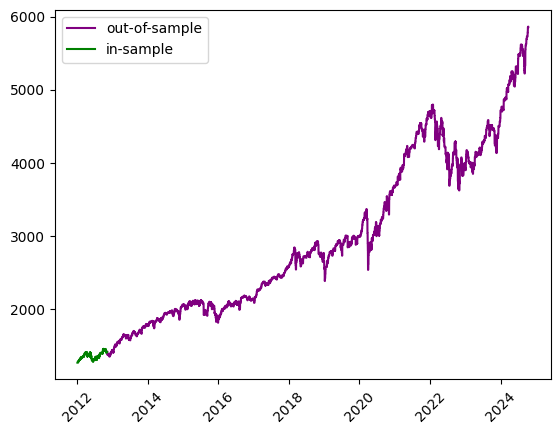

In [9]:
trainer.excluded_features = trainer.excluded_features + ['spot_price','strike_price','barrier','rebate',relative_pricename,'relative_observed']
trainer.load_data(data)
dates = data['date'].sort_values().drop_duplicates().reset_index(drop=True)
development_dates = dates[:100]
test_dates = dates[~dates.isin(development_dates)]
trainer.target_name = targetname
trainer.preprocess_data(development_dates=development_dates,test_dates=test_dates)

In [10]:
help(trainer)

Help on convsklearn in module convsklearn.convsklearn object:

class convsklearn(builtins.object)
 |  convsklearn(target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |
 |  a proprietary class of convenience wrappers for sklearn
 |
 |  Methods defined here:
 |
 |  __init__(self, target_name='observed_price', excluded_features=['barrier_price', 'asian_price', 'observed_price', 'outin', 'updown', 'n_fixings'], seed=1312)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  fit_mlp(self, print_details=True)
 |
 |  fit_scaled_target_mlp(self, print_details=True)
 |
 |  load_data(self, data)
 |
 |  preprocess_data(self, development_dates, test_dates, plot=True)
 |
 |  test_prediction_accuracy(self)
 |
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |
 |  __dict__
 |      dictionary for instance variables
 |
 |  __w

In [11]:
trainer.fit_mlp()
trainer.test_prediction_accuracy()


training on 266781 samples...

hidden_layer_sizes: (10, 10)
max_iter: 500
random_state: 1312
early_stopping: False
learning_rate: constant
learning_rate_init: 0.001
n_iter_no_change: 20
power_t: 0.5
tol: 0.001
cpu: 10.766070365905762

in sample:
     RMSE: 0.02497328852191334
     MAE: 0.013760976844584735

out of sample:
     RMSE: 0.08915176409684406
     MAE: 0.04138887867557739


{'train_data':         spot_price  strike_price  barrier  days_to_maturity updown outin  \
 0           1274.0       1146.60   637.00                60   Down   Out   
 1448        1274.0       1242.15  1286.74               180     Up   Out   
 1447        1274.0       1242.15  1286.74                90     Up    In   
 1446        1274.0       1242.15  1286.74                90     Up    In   
 1445        1274.0       1242.15  1286.74                90     Up   Out   
 ...            ...           ...      ...               ...    ...   ...   
 281691      1420.0       1526.50  1057.90                60   Down    In   
 281689      1420.0       1526.50  1057.90                60   Down   Out   
 281687      1420.0       1526.50   883.95               720   Down    In   
 281703      1420.0       1526.50  1057.90               360   Down    In   
 282959      1420.0       1562.00  2130.00               720     Up    In   
 
            w barrier_type_name  rebate  dividend_rate  ... 